In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import time

os.environ['PREFECT__FLOWS__CHECKPOINTING'] = 'true'

from funnel import CacheStore
from funnel.prefect.result import FunnelResult
from prefect import task, Flow, Parameter
from prefect.executors import DaskExecutor
import xarray as xr

In [3]:
os.environ.get("AZURE_STORAGE_CONNECTION_STRING")

'DefaultEndpointsProtocol=https;AccountName=cmip6downscaling;AccountKey=q2TSTCMWAAf0IRwwZc3Yhhi8vrvYkRynAvS5FPl0amcqZ/gXpbB1BCfYmUYBwasJPYb9VrPjlBHgEwY3M84nSA==;EndpointSuffix=core.windows.net'

In [4]:
import fsspec
import os 
connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")

fs = fsspec.filesystem('az', connection_string=connection_string)

# # # fs.ls('flow-outputs/')

# # fs.rm('flow-outputs/intermediate/bias_corrected_gcm',recursive=True)
# # fs.rm('flow-outputs/intermediate/funnel_metadata_store/bias_corrected_gcm',recursive=True)
# # fs.rm('flow-outputs/intermediate/bias_corrected_obs',recursive=True)
# # fs.rm('flow-outputs/intermediate/funnel_metadata_store/bias_corrected_obs',recursive=True)
# fs.rm('flow-outputs/intermediate/interpolated_obs',recursive=True)
# fs.rm('flow-outputs/intermediate/epoch_adjusted_gcm', recursive=True)
# fs.rm('flow-outputs/intermediate/gcm_epoch_trend', recursive=True)
# fs.rm('flow-outputs/intermediate/maca_epoch_adjusted_downscaled_output', recursive=True)
# fs.rm('flow-outputs/intermediate/epoch_replaced_gcm', recursive=True)

# fs.rm('flow-outputs/intermediate/maca_test_bias_correction_rechunk.zarr', recursive=True)
# fs.rm('flow-outputs/intermediate/maca_epoch_adjusted_downscaled_output/MIROC6_ssp370_1991_1995_2071_2075_tasmax_tasmax_0.0_-90.0_360.0_90.0.zarr', recursive=True)
# fs.rm('flow-outputs/intermediate/rechunked_obs/ERA5_1991_1995_tasmax_full_time.zarr', recursive=True)


In [5]:
run_hyperparameters = {
    "OBS": "ERA5",
    "GCM": "MIROC6",
    "SCENARIO": "ssp370",
    "LABEL": "tasmax",
    "TRAIN_PERIOD_START": "1991",
    "TRAIN_PERIOD_END": "1995",
    "PREDICT_PERIOD_START": "2071",
    "PREDICT_PERIOD_END": "2075",
    "EPOCH_ADJUSTMENT_DAY_ROLLING_WINDOW": 21, 
    "EPOCH_ADJUSTMENT_YEAR_ROLLING_WINDOW": 3,
    "BIAS_CORRECTION_BATCH_SIZE": 15,
    "BIAS_CORRECTION_BUFFER_SIZE": 15,
    "CONSTRUCTED_ANALOG_N_ANALOGS": 10,
    "CONSTRUCTED_ANALOG_DOY_RANGE": 45,
}


In [7]:
from cmip6_downscaling.workflows.maca_flow import maca_flow

In [ ]:
maca_flow.run(parameters=run_hyperparameters)

[2022-01-08 06:58:33+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'maca-flow'
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'SCENARIO': Starting task run...
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'SCENARIO': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'BIAS_CORRECTION_BATCH_SIZE': Starting task run...
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'BIAS_CORRECTION_BATCH_SIZE': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'BIAS_CORRECTION_BUFFER_SIZE': Starting task run...
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'BIAS_CORRECTION_BUFFER_SIZE': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'PREDICT_PERIOD_START': Starting task run...
[2022-01-08 06:58:33+0000] INFO - prefect.TaskRunner | Task 'PREDICT_PE

/home/jovyan/cmip6-downscaling/cmip6_downscaling/workflows/utils.py:526: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  output = xr.open_zarr(target_store)


[2022-01-08 06:58:36+0000] INFO - prefect.TaskRunner | Task 'get_obs': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:36+0000] INFO - prefect.TaskRunner | Task 'path_builder_task': Starting task run...
[2022-01-08 06:58:37+0000] INFO - prefect.TaskRunner | Task 'path_builder_task': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:37+0000] INFO - prefect.TaskRunner | Task 'get_gcm': Starting task run...


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/note

target path is az://flow-outputs/intermediate/rechunked_gcm/MIROC6_ssp370_1991_1995_2071_2075_tasmax_full_time.zarr
checking the cache
[2022-01-08 06:58:38+0000] INFO - prefect.TaskRunner | Task 'get_gcm': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:38+0000] INFO - prefect.TaskRunner | Task 'get_obs': Starting task run...
target path is az://flow-outputs/intermediate/rechunked_obs/ERA5_1991_1995_tasmax_full_time.zarr
checking the cache


/home/jovyan/cmip6-downscaling/cmip6_downscaling/workflows/utils.py:526: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  output = xr.open_zarr(target_store)


[2022-01-08 06:58:41+0000] INFO - prefect.TaskRunner | Task 'get_obs': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:41+0000] INFO - prefect.TaskRunner | Task 'path_builder_task[2]': Starting task run...
[2022-01-08 06:58:41+0000] INFO - prefect.TaskRunner | Task 'path_builder_task[2]': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:41+0000] INFO - prefect.TaskRunner | Task 'List': Starting task run...
[2022-01-08 06:58:41+0000] INFO - prefect.TaskRunner | Task 'List': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:41+0000] INFO - prefect.TaskRunner | Task 'calc_epoch_trend_task': Starting task run...
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'calc_epoch_trend_task': Finished task run for task with final state: 'Cached'
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'path_builder_task[1]': Starting task run...
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'path_bu

/srv/conda/envs/notebook/lib/python3.9/site-packages/regionmask/core/regions.py:410: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for p in poly:


[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'get_subdomains_task': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'get_subdomains_task[0]': Starting task run...
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'get_subdomains_task[0]': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'get_subdomains_task[3]': Starting task run...
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'get_subdomains_task[3]': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'Mul': Starting task run...
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'Mul': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunner | Task 'path_builder_task[0]': Starting task run...
[2022-01-08 06:58:42+0000] INFO - prefect.TaskRunne

/home/jovyan/cmip6-downscaling/cmip6_downscaling/workflows/utils.py:526: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  output = xr.open_zarr(target_store)


[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'rechunker_task': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task': Starting task run...
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task[1]': Starting task run...
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task[1]': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task[0]': Starting task run...
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task[0]': Finished task run for task with final state: 'Success'
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task[2]': Starting task run...
[2022-01-08 06:58:46+0000] INFO - prefect.TaskRunner | Task 'subset_task[2]': 

/home/jovyan/cmip6-downscaling/cmip6_downscaling/workflows/utils.py:526: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  output = xr.open_zarr(target_store)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[46 47 48 49 50 51 52 53 54 55 56 57 58 59 60]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[106 107 108 109 110 111 112 113 114 115 116 117 118 119 120]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[121 122 123 124 125 126 127 128 129 130 131 132 133 134 135]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[136 137 138 139 140 141 142 143 144 145 146 147 148 149 150]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


[151 152 153 154 155 156 157 158 159 160 161 162 163 164 165]


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [10]:
ds = xr.open_zarr('az://flow-outputs/intermediate/maca_test_fine_bias_correction_rechunk.zarr')

/tmp/ipykernel_24092/3943829077.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  ds = xr.open_zarr('az://flow-outputs/intermediate/maca_test_fine_bias_correction_rechunk.zarr')


In [11]:
ds

<xarray.Dataset>
Dimensions:    (time: 3650, lat: 721, lon: 1440)
Coordinates:
    dayofyear  (time) int64 dask.array<chunksize=(3650,), meta=np.ndarray>
  * lat        (lat) float32 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
  * lon        (lon) float32 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1991-01-01T12:00:00 ... 2075-12-31T12:00:00
Data variables:
    tasmax     (lat, lon, time) float64 dask.array<chunksize=(42, 42, 1826), meta=np.ndarray>

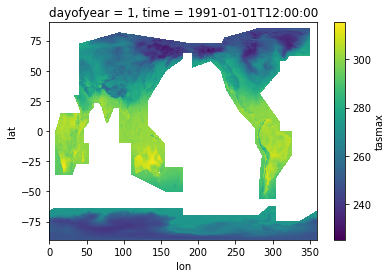

In [12]:
ds.tasmax.isel(time=0).plot()

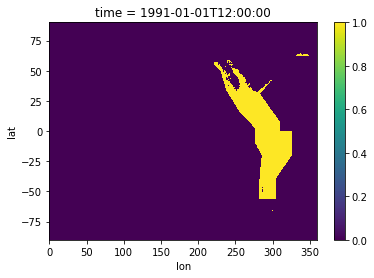

In [26]:
((ds.tasmax > 280) & (ds.lon > 180)).isel(time=0).plot()

In [ ]:
print('done')